<a href="https://colab.research.google.com/github/gkondayya/ACP2021/blob/main/momentum12mo_rebal_nifty_smallcap250.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install yfinance

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import copy
import matplotlib.pyplot as plt

In [3]:
def CAGR(DF):
    "function to calculate the Cumulative Annual Growth Rate of a trading strategy"
    df = DF.copy()
    df["cum_return"] = (1 + df["mon_ret"]).cumprod()
    n = len(df)/12 # n = no. of years, so for daily data replace 12 with 252 (12 is used for now for monthly data)  
    CAGR = (df["cum_return"].tolist()[-1])**(1/n) - 1
    return CAGR

def volatility(DF):
    "function to calculate annualized volatility of a trading strategy"
    df = DF.copy()
    vol = df["mon_ret"].std() * np.sqrt(12)
    return vol

def sharpe(DF,rf):
    "function to calculate sharpe ratio ; rf is the risk free rate"
    df = DF.copy()
    sr = (CAGR(df) - rf)/volatility(df)
    return sr
    

def max_dd(DF):
    "function to calculate max drawdown"
    df = DF.copy()
    df["cum_return"] = (1 + df["mon_ret"]).cumprod()
    df["cum_roll_max"] = df["cum_return"].cummax()
    df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
    df["drawdown_pct"] = df["drawdown"]/df["cum_roll_max"]
    max_dd = df["drawdown_pct"].max()
    return max_dd

In [4]:
# Conver list of NSE stocks to listcol_one_list = df['one'].tolist()
import pandas as pd
from google.colab import files
uploaded = files.upload()

df1 = pd.read_csv('ind_niftysmallcap250list.csv')

df1.head()
NSE_tickers = df1['Symbol'].tolist()

Saving ind_niftysmallcap250list.csv to ind_niftysmallcap250list.csv


In [5]:
#tickers = ["AFFLE.NS", "AMBER.NS", "ASIANPAINT.NS", "BAJAJHIND.NS", "BAJFINANCE.NS", "BALKRISIND.NS", "BSE.NS", "CLEAN.NS", "CUPID.NS" , \
#"DIXON.NS", "DMART.NS", "EQUITAS.NS", "HDFC.NS", "HDFCBANK.NS", "ICICIBANK.NS", "IDFC.NS", "IEX.NS", "INFY.NS", "INOXLEISUR.NS" , \
#"IRCTC.NS", "ISGEC.NS", "JPPOWER.NS", "JUBLFOOD.NS", "LIKHITHA.NS", "LT.NS", "MOLDTKPAC.NS","MOTHERSUMI.NS", "NELCO.NS", \
#"PIIND.NS", "POLYCAB.NS", "PRAJIND.NS", "PRECWIRE.NS", "PVR.NS", "RELIANCE.NS", "SBIN.NS", "TATACHEM.NS", "TATAMOTORS.NS", \
#"TCS.NS", "TECHM.NS", "YESBANK.NS", "ZENSARTECH.NS"]
ext = ".NS" 
tickers = [t + ext for t in NSE_tickers ]

tickers[0:5]

['AARTIDRUGS.NS',
 'ADVENZYMES.NS',
 'AEGISCHEM.NS',
 'ALEMBICLTD.NS',
 'ALOKINDS.NS']

In [17]:
ohlc_mon = {} # directory with ohlc value for each stock            
start = dt.datetime.today()-dt.timedelta(3650)
end = dt.datetime.today()


In [18]:
# looping over tickers and creating a dataframe with close prices
for ticker in tickers:
    ohlc_mon[ticker] = yf.download(ticker,start,end,interval='1mo')
    ohlc_mon[ticker].dropna(inplace=True,how="all")
 
tickers = ohlc_mon.keys() # redefine tickers variable after removing any tickers with corrupted data

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [19]:
# calculating monthly return for each stock and consolidating return info by stock in a separate dataframe
ohlc_dict = copy.deepcopy(ohlc_mon)
return_df = pd.DataFrame()
yreturn_df = pd.DataFrame()
for ticker in tickers:
    print("calculating monthly return for ",ticker)
    ohlc_dict[ticker]["mon_ret"] = ohlc_dict[ticker]["Adj Close"].pct_change()
    ohlc_dict[ticker]["yr_ret"] = ohlc_dict[ticker]["Adj Close"].pct_change(periods=12)
    return_df[ticker] = ohlc_dict[ticker]["mon_ret"]
    yreturn_df[ticker] = ohlc_dict[ticker]["yr_ret"]
    return_df.fillna(0,inplace=True)
    yreturn_df.fillna(0,inplace=True)
#return_df.dropna(inplace=True)
#return_df.tail()


calculating monthly return for  AARTIDRUGS.NS
calculating monthly return for  ADVENZYMES.NS
calculating monthly return for  AEGISCHEM.NS
calculating monthly return for  ALEMBICLTD.NS
calculating monthly return for  ALOKINDS.NS
calculating monthly return for  AMBER.NS
calculating monthly return for  ANGELONE.NS
calculating monthly return for  ANURAS.NS
calculating monthly return for  ASAHIINDIA.NS
calculating monthly return for  ASHOKA.NS
calculating monthly return for  ASTERDM.NS
calculating monthly return for  ASTRAZEN.NS
calculating monthly return for  AVANTIFEED.NS
calculating monthly return for  BASF.NS
calculating monthly return for  BEML.NS
calculating monthly return for  BSE.NS
calculating monthly return for  BAJAJCON.NS
calculating monthly return for  BAJAJELEC.NS
calculating monthly return for  BALAMINES.NS
calculating monthly return for  BALRAMCHIN.NS
calculating monthly return for  MAHABANK.NS
calculating monthly return for  BDL.NS
calculating monthly return for  BHARATRAS.N

In [20]:
# function to calculate portfolio return iteratively
def pflio(mDF,yDF,m,x):
    """Returns cumulative portfolio return
    DF = dataframe with monthly return info for all stocks
    m = number of stock in the portfolio
    x = number of underperforming stocks to be removed from portfolio monthly"""
    df = mDF.copy()
    ydf = yDF.copy()
    portfolio = []
    monthly_ret = [0]
    for i in range(len(df)):
        if len(portfolio) > 0:
            monthly_ret.append(df[portfolio].iloc[i,:].mean())
            bad_stocks = ydf[portfolio].iloc[i,:].sort_values(ascending=True)[:x].index.values.tolist()
            portfolio = [t for t in portfolio if t not in bad_stocks]
        fill = m - len(portfolio)
        new_picks = ydf.iloc[i,:].sort_values(ascending=False)[:fill].index.values.tolist()
        portfolio = portfolio + new_picks
        print(portfolio)
    monthly_ret_df = pd.DataFrame(np.array(monthly_ret),columns=["mon_ret"])
    return monthly_ret_df


In [26]:
#pflio(return_df,yreturn_df,42,20).head()

#calculating overall strategy's KPIs
CAGR(pflio(return_df,yreturn_df,12,6))
#sharpe(pflio(return_df,6,3),0.025)
#max_dd(pflio(return_df,6,3)) 

['ECLERX.NS', 'GREAVESCOT.NS', 'HEMIPROP.NS', 'HEIDELBERG.NS', 'HATHWAY.NS', 'HAPPSTMNDS.NS', 'HFCL.NS', 'HEG.NS', 'GSFC.NS', 'GPPL.NS', 'GNFC.NS', 'FLUOROCHEM.NS']
['HFCL.NS', 'HEG.NS', 'GSFC.NS', 'GPPL.NS', 'GNFC.NS', 'FLUOROCHEM.NS', 'ECLERX.NS', 'GREAVESCOT.NS', 'HEMIPROP.NS', 'HEIDELBERG.NS', 'HATHWAY.NS', 'HAPPSTMNDS.NS']
['ECLERX.NS', 'GREAVESCOT.NS', 'HEMIPROP.NS', 'HEIDELBERG.NS', 'HATHWAY.NS', 'HAPPSTMNDS.NS', 'ECLERX.NS', 'GREAVESCOT.NS', 'HEMIPROP.NS', 'HEIDELBERG.NS', 'HATHWAY.NS', 'HAPPSTMNDS.NS']
['ECLERX.NS', 'GREAVESCOT.NS', 'HEMIPROP.NS', 'HEIDELBERG.NS', 'HATHWAY.NS', 'HAPPSTMNDS.NS', 'HFCL.NS', 'HEG.NS', 'GSFC.NS', 'GPPL.NS', 'GNFC.NS', 'FLUOROCHEM.NS']
['HFCL.NS', 'HEG.NS', 'GSFC.NS', 'GPPL.NS', 'GNFC.NS', 'FLUOROCHEM.NS', 'ECLERX.NS', 'GREAVESCOT.NS', 'HEMIPROP.NS', 'HEIDELBERG.NS', 'HATHWAY.NS', 'HAPPSTMNDS.NS']
['ECLERX.NS', 'GREAVESCOT.NS', 'HEMIPROP.NS', 'HEIDELBERG.NS', 'HATHWAY.NS', 'HAPPSTMNDS.NS', 'ECLERX.NS', 'GREAVESCOT.NS', 'HEMIPROP.NS', 'HEIDELBERG.NS

0.6308568425176562

[*********************100%***********************]  1 of 1 completed
['ECLERX.NS', 'GREAVESCOT.NS', 'HEMIPROP.NS', 'HEIDELBERG.NS', 'HATHWAY.NS', 'HAPPSTMNDS.NS', 'HFCL.NS', 'HEG.NS', 'GSFC.NS', 'GPPL.NS', 'GNFC.NS', 'FLUOROCHEM.NS']
['HFCL.NS', 'HEG.NS', 'GSFC.NS', 'GPPL.NS', 'GNFC.NS', 'FLUOROCHEM.NS', 'ECLERX.NS', 'GREAVESCOT.NS', 'HEMIPROP.NS', 'HEIDELBERG.NS', 'HATHWAY.NS', 'HAPPSTMNDS.NS']
['ECLERX.NS', 'GREAVESCOT.NS', 'HEMIPROP.NS', 'HEIDELBERG.NS', 'HATHWAY.NS', 'HAPPSTMNDS.NS', 'ECLERX.NS', 'GREAVESCOT.NS', 'HEMIPROP.NS', 'HEIDELBERG.NS', 'HATHWAY.NS', 'HAPPSTMNDS.NS']
['ECLERX.NS', 'GREAVESCOT.NS', 'HEMIPROP.NS', 'HEIDELBERG.NS', 'HATHWAY.NS', 'HAPPSTMNDS.NS', 'HFCL.NS', 'HEG.NS', 'GSFC.NS', 'GPPL.NS', 'GNFC.NS', 'FLUOROCHEM.NS']
['HFCL.NS', 'HEG.NS', 'GSFC.NS', 'GPPL.NS', 'GNFC.NS', 'FLUOROCHEM.NS', 'ECLERX.NS', 'GREAVESCOT.NS', 'HEMIPROP.NS', 'HEIDELBERG.NS', 'HATHWAY.NS', 'HAPPSTMNDS.NS']
['ECLERX.NS', 'GREAVESCOT.NS', 'HEMIPROP.NS', 'HEIDELBERG.NS', 'HATHWAY.NS', 'HAPPST

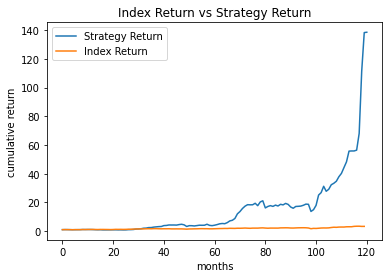

In [27]:
#calculating KPIs for Index buy and hold strategy over the same period
Nifty50 = yf.download("^NSEI",dt.date.today()-dt.timedelta(3650),dt.date.today(),interval='1mo')
Nifty50["mon_ret"] = Nifty50["Adj Close"].pct_change().fillna(0)
CAGR(Nifty50)
sharpe(Nifty50,0.025)
max_dd(Nifty50)

#visualization
fig, ax = plt.subplots()
plt.plot((1+pflio(return_df,yreturn_df,12,6)).cumprod())
plt.plot((1+Nifty50["mon_ret"].reset_index(drop=True)).cumprod())
plt.title("Index Return vs Strategy Return")
plt.ylabel("cumulative return")
plt.xlabel("months")
ax.legend(["Strategy Return","Index Return"])